In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

data_dir = "/kaggle/input/rice-image-dataset/Rice_Image_Dataset/"

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tqdm import tqdm
import os

images = []
labels = []

for class_name in tqdm(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert("RGB").resize((64, 64))
        images.append(np.array(img))
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)


100%|██████████| 6/6 [03:57<00:00, 39.64s/it]


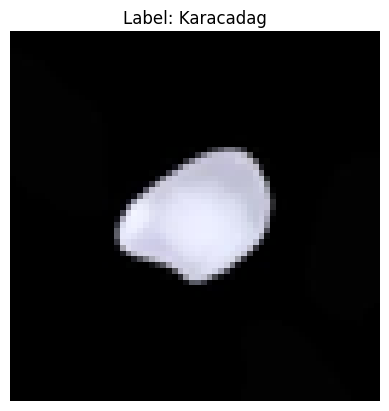

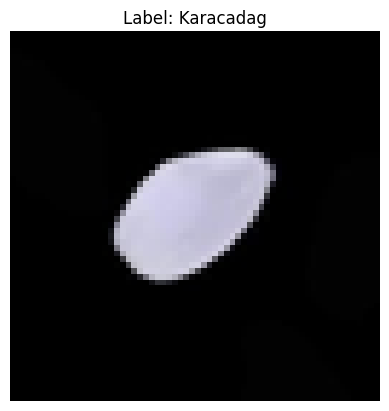

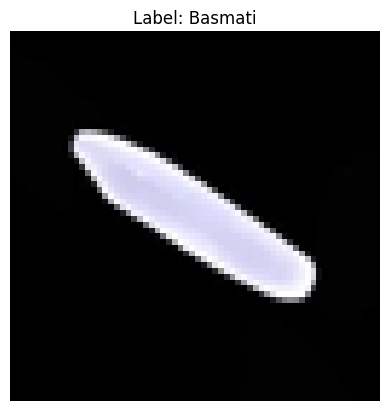

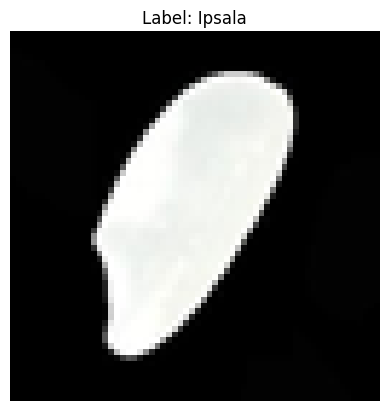

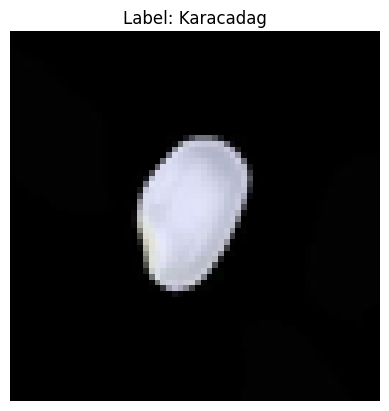

In [3]:
import random

for i in range(5):
    idx = random.randint(0, len(images) - 1)
    plt.imshow(images[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis("off")
    plt.show()


In [4]:
images = images/255

In [5]:
images[0].shape

(64, 64, 3)

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [9]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [10]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,32,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32,64,3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(-1, 64 * 16 * 16)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [15]:
model = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
import time

epochs = 10
total_start_time = time.time()  

for epoch in range(epochs):
    epoch_start_time = time.time()

    correct = 0
    total = 0
    running_loss = 0.0

    model.train()

    for images, labels in trainloader:
        images = images.permute(0, 3, 1, 2) 
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(trainloader)
    accuracy = correct / total

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={accuracy:.4f}, Time={epoch_time:.2f}s")

total_end_time = time.time()
total_time = total_end_time - total_start_time
print(f"\nTotal training time: {total_time:.2f} seconds")


Epoch 1: Loss=0.0131, Accuracy=0.9955, Time=210.94s
Epoch 2: Loss=0.0098, Accuracy=0.9968, Time=211.06s
Epoch 3: Loss=0.0176, Accuracy=0.9940, Time=211.21s
Epoch 4: Loss=0.0116, Accuracy=0.9961, Time=213.10s
Epoch 5: Loss=0.0094, Accuracy=0.9968, Time=212.20s
Epoch 6: Loss=0.0087, Accuracy=0.9971, Time=214.10s
Epoch 7: Loss=0.0091, Accuracy=0.9969, Time=213.81s
Epoch 8: Loss=0.0085, Accuracy=0.9973, Time=215.01s
Epoch 9: Loss=0.0058, Accuracy=0.9980, Time=223.69s
Epoch 10: Loss=0.0069, Accuracy=0.9975, Time=221.54s

Total training time: 2146.68 seconds


In [20]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images = images.permute(0, 3, 1, 2) 
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(correct, total)

accuracy = 100 * correct / total
print(f"Test Accuracy on mnist_test.csv: {accuracy:.2f}%")

14948 15000
Test Accuracy on mnist_test.csv: 99.65%


In [24]:
images, labels = next(iter(testloader))

with torch.no_grad():
    images = images.permute(0, 3, 1, 2) 
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

 
print(predicted)

tensor([1, 3, 4, 1, 3, 2, 0, 4, 4, 0, 0, 0, 1, 3, 2, 3, 2, 1, 0, 1, 0, 1, 3, 0,
        2, 1, 0, 1, 0, 4, 0, 0, 0, 2, 1, 2, 2, 3, 1, 1, 2, 4, 3, 0, 2, 2, 2, 0,
        0, 1, 4, 4, 4, 2, 2, 0, 1, 3, 3, 0, 1, 3, 3, 1])


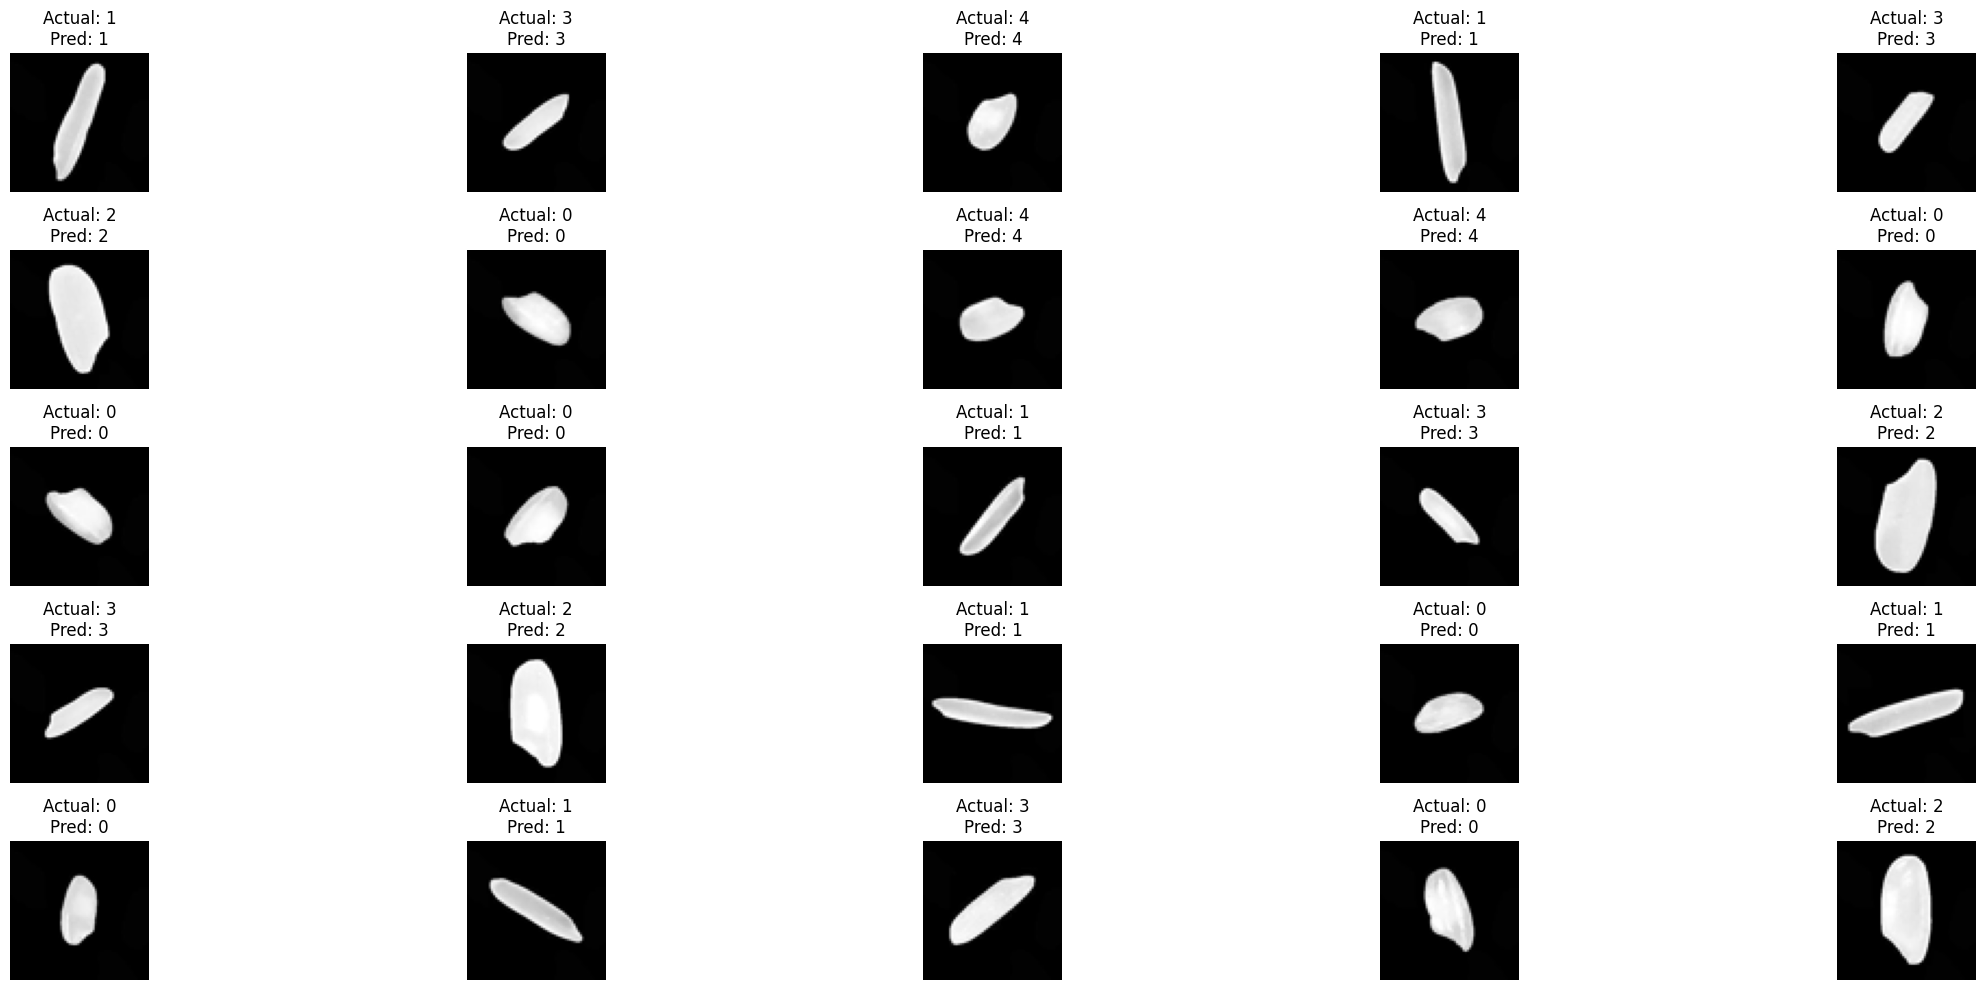

In [25]:
fig = plt.figure(figsize=(25, 10))
for idx in range(25):
    ax = fig.add_subplot(5, 5, idx+1)
    ax.imshow(images[idx][0], cmap='gray') 
    ax.set_title(f"Actual: {labels[idx].item()}\nPred: {predicted[idx].item()}")
    ax.axis('off')

plt.tight_layout()
plt.show()